In [1]:
#Importing the Libraries
import numpy as np
import pandas as pd
import datetime
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt, numpy as np
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import AgglomerativeClustering
from matplotlib.colors import ListedColormap
from sklearn import metrics
import warnings
import sys
if not sys.warnoptions:
    warnings.simplefilter("ignore")
np.random.seed(42)

c:\Users\Nat\anaconda3\lib\site-packages\pandas\core\computation\expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
# Para mostrar todas as colunas do dataset
pd.options.display.max_columns = None


# Carregando o dataset

df = pd.read_csv("marketing_campaign.csv", sep="\t")
len(df) #quantidade de registros
df.head()



,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,04-09-2012,58,635,88,546,172,88,88,3,8,10,4,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,08-03-2014,38,11,1,6,2,1,6,2,1,1,2,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,21-08-2013,26,426,49,127,111,21,42,1,8,2,10,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,10-02-2014,26,11,4,20,10,3,5,2,2,0,4,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,19-01-2014,94,173,43,118,46,27,15,5,5,3,6,5,0,0,0,0,0,0,3,11,0


In [3]:
# Informações sobre as features
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 29 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   2240 non-null   int64  
 1   Year_Birth           2240 non-null   int64  
 2   Education            2240 non-null   object 
 3   Marital_Status       2240 non-null   object 
 4   Income               2216 non-null   float64
 5   Kidhome              2240 non-null   int64  
 6   Teenhome             2240 non-null   int64  
 7   Dt_Customer          2240 non-null   object 
 8   Recency              2240 non-null   int64  
 9   MntWines             2240 non-null   int64  
 10  MntFruits            2240 non-null   int64  
 11  MntMeatProducts      2240 non-null   int64  
 12  MntFishProducts      2240 non-null   int64  
 13  MntSweetProducts     2240 non-null   int64  
 14  MntGoldProds         2240 non-null   int64  
 15  NumDealsPurchases    2240 non-null   i

In [4]:
# Existem valores nulos (NA) em Income, então vamos excluir esses registros
df = df.dropna()

# Número de registros agora
len(df)

2216

In [5]:
# Trabalhando com a feature Dt_customer: desde quando a pessoa é cliente

# passando de objetct para datetime
df['Dt_Customer'] = pd.to_datetime(df['Dt_Customer'], format="%d-%m-%Y")

dates = []
#como é um timestamp, aqui pega apenas a parte de data, sem as horas
for i in df['Dt_Customer']:
    i = i.date()
    dates.append(i)

# a ideia é criar uma feature com o número de dias que a pessoa é cliente

days = []
d1 = max(dates) #cliente mais novo
for i in dates:
    delta = d1 - i
    days.append(delta)

df['Customer_For'] = days
df['Customer_For'] = pd.to_numeric(df['Customer_For'], errors='coerce')

In [6]:
# Feature engineering

# Extraindo a idade do cliente do ano de nascimento
df['Age'] = 2024 - df['Year_Birth']

# Criando feature com total gasto em vários itens
df['Spent'] = df["MntWines"]+ df["MntFruits"]+ df["MntMeatProducts"]+ df["MntFishProducts"]+ df["MntSweetProducts"]+ df["MntGoldProds"]

# Criando feature derivada de Marital Status para indicar se a pessoa mora sozinha ou com alguém
df['LivingWith'] = df['Marital_Status'].replace({"Married":"Partner", "Together":"Partner", "Absurd":"Alone", "Widow":"Alone", "YOLO":"Alone", "Divorced":"Alone", "Single":"Alone"})

# Criando feature indicando o total de crianças/adolescentes na casa
df['Children'] = df['Kidhome'] + df['Teenhome']

# Criando feature para total de membros da família vivendo na casa
df['Family_Size'] = df['LivingWith'].replace({"Alone":1, "Partner":2}) + df['Children']

# Criando feature sobre o cliente ser pai ou não
df['Is_Parent'] = np.where(df.Children > 0, 1, 0)

# Criando feature para segmentar educação em três tipos
df["Education"] = df["Education"].replace({"Basic":"Undergraduate","2n Cycle":"Undergraduate", "Graduation":"Graduate", "Master":"Postgraduate", "PhD":"Postgraduate"})

# Melhorando a nomenclatura das features correspondentes ao total gasto em alguns determinados produtos
df = df.rename(columns={"MntWines": "Wines","MntFruits":"Fruits","MntMeatProducts":"Meat","MntFishProducts":"Fish","MntSweetProducts":"Sweets","MntGoldProds":"Gold"})

# Deletando features desnecessárias
df = df.drop(["Marital_Status", "Dt_Customer", "Z_CostContact", "Z_Revenue", "Year_Birth", "ID"], axis=1)

df.describe()

,Income,Kidhome,Teenhome,Recency,Wines,Fruits,Meat,Fish,Sweets,Gold,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Response,Customer_For,Age,Spent,Children,Family_Size,Is_Parent
count,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2.216000e+03,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000
mean,52247.251354,0.441787,0.505415,49.012635,305.091606,26.356047,166.995939,37.637635,27.028881,43.965253,2.323556,4.085289,2.671029,5.800993,5.319043,0.073556,0.074007,0.073105,0.064079,0.013538,0.009477,0.150271,3.054423e+16,55.179603,607.075361,0.947202,2.592509,0.714350
std,25173.076661,0.536896,0.544181,28.948352,337.327920,39.793917,224.283273,54.752082,41.072046,51.815414,1.923716,2.740951,2.926734,3.250785,2.425359,0.261106,0.261842,0.260367,0.244950,0.115588,0.096907,0.357417,1.749036e+16,11.985554,602.900476,0.749062,0.905722,0.451825
min,1730.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,28.000000,5.000000,0.000000,1.000000,0.000000
25%,35303.000000,0.000000,0.000000,24.000000,24.000000,2.000000,16.000000,3.000000,1.000000,9.000000,1.000000,2.000000,0.000000,3.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.555200e+16,47.000000,69.000000,0.000000,2.000000,0.000000
50%,51381.500000,0.000000,0.000000,49.000000,174.500000,8.000000,68.000000,12.000000,8.000000,24.500000,2.000000,4.000000,2.000000,5.000000,6.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.071520e+16,54.000000,396.500000,1.000000,3.000000,1.000000
75%,68522.000000,1.000000,1.000000,74.000000,505.000000,33.000000,232.250000,50.000000,33.000000,56.000000,3.000000,6.000000,4.000000,8.000000,7.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.570560e+16,65.000000,1048.000000,1.000000,3.000000,1.000000
max,666666.000000,2.000000,2.000000,99.000000,1493.000000,199.000000,1725.000000,259.000000,262.000000,321.000000,15.000000,27.000000,28.000000,13.000000,20.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,6.039360e+16,131.000000,2525.000000,3.000000,5.000000,1.000000


Gráfico relativo a algumas features


<Figure size 576x396 with 0 Axes>

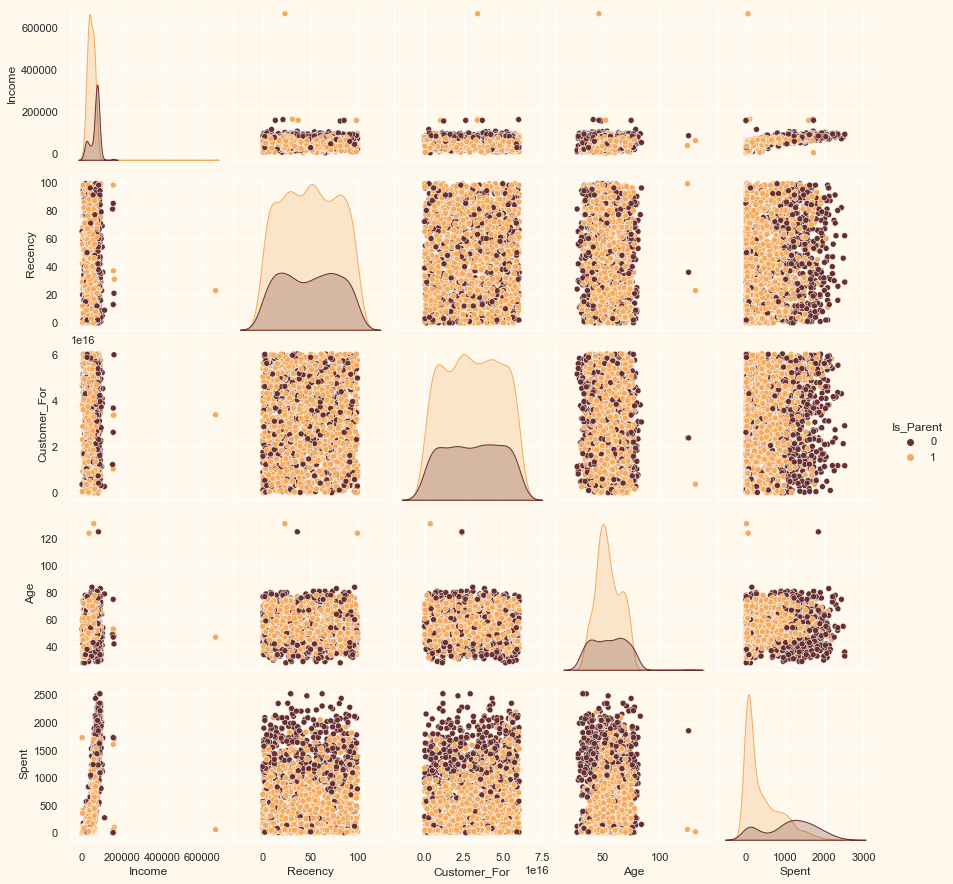

In [7]:
# Plotando algumas features

# color preferences
sns.set_theme(rc={"axes.facecolor":"#FFF9ED","figure.facecolor":"#FFF9ED"})
pallet = ["#682F2F", "#9E726F", "#D6B2B1", "#B9C0C9", "#9F8A78", "#F3AB60"]
cmap = colors.ListedColormap(["#682F2F", "#9E726F", "#D6B2B1", "#B9C0C9", "#9F8A78", "#F3AB60"])

# features
to_plot = ["Income", "Recency", "Customer_For", "Age", "Spent", "Is_Parent"]

print("Gráfico relativo a algumas features")
plt.figure()
# pairplot: to plot multiple pairwise bivariate distributions in a dataset
sns.pairplot(df[to_plot], hue="Is_Parent", palette= (["#682F2F","#F3AB60"]))

plt.show()

In [8]:
# com o gráfico acima foi possível perceber alguns outliers em Income e Age
# deletando os outliers estabelecendo um limite

df = df[(df["Age"] < 90)]
df = df[(df["Income"] < 600000)]

# verificando novo total de registros
len(df)

2212

<Axes: >

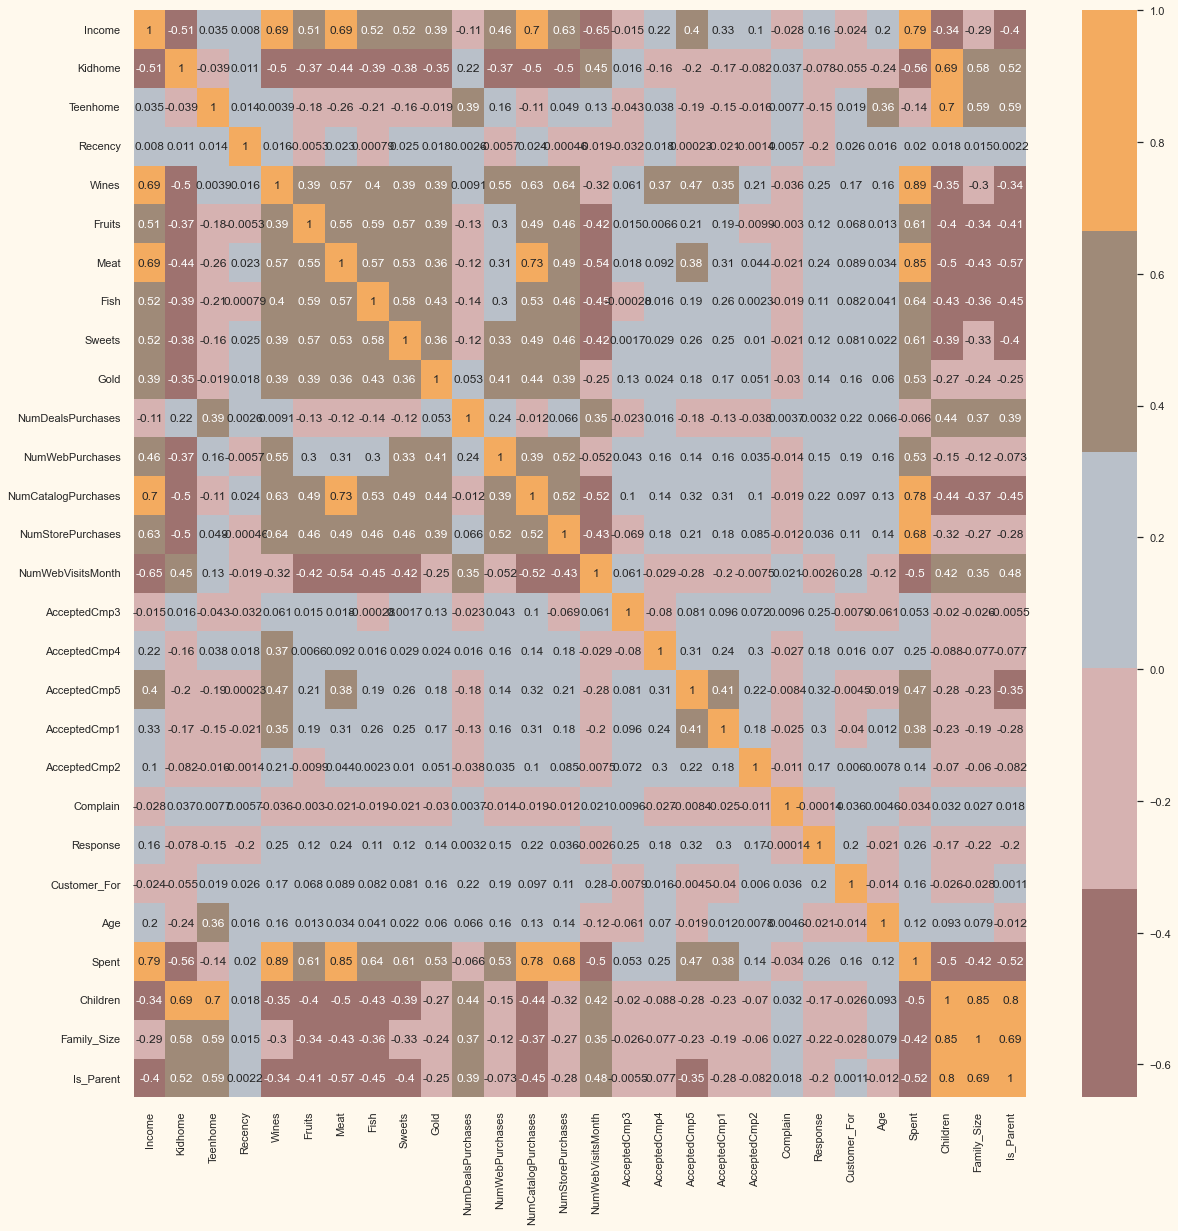

In [9]:
# Analisando as correlações entre as features (por enquanto, sem considerar as categóricas)

# matriz de correlações

corr_mat = df.corr(numeric_only=True)
plt.figure(figsize=(20,20))
sns.heatmap(corr_mat, annot=True, cmap=cmap, center=0)


In [10]:
# Pré-processamento dos dados - antes da clusterização

# buscando variáveis categóricas
v = (df.dtypes == 'object')
object_cols = list(v[v].index) #lista com as duas variáveis categóricas
print("Variáveis Categóricas: ", object_cols)


Variáveis Categóricas:  ['Education', 'LivingWith']


In [11]:
# Label encoding nas variáveis categóricas

le = LabelEncoder()
for i in object_cols:
    df[i] = df[[i]].apply(le.fit_transform)

In [12]:
ds = df.copy()

# colunas que não serão usadas no modelo
cols_del = ['AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1','AcceptedCmp2', 'Complain', 'Response']
ds = ds.drop(cols_del, axis=1)
# Colocando os dados numa mesma escala de forma que a média seja 0 e o desvio padrão seja 1
scaler = StandardScaler() 
ds_scaled = pd.DataFrame(scaler.fit_transform(ds), columns=ds.columns)
ds_scaled.head()


,Education,Income,Kidhome,Teenhome,Recency,Wines,Fruits,Meat,Fish,Sweets,Gold,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,Customer_For,Age,Spent,LivingWith,Children,Family_Size,Is_Parent
0,-0.893586,0.287105,-0.822754,-0.929699,0.310353,0.977660,1.552041,1.690293,2.453472,1.483713,0.852576,0.351030,1.426865,2.503607,-0.555814,0.692181,1.527721,1.018352,1.676245,-1.349603,-1.264598,-1.758359,-1.581139
1,-0.893586,-0.260882,1.040021,0.908097,-0.380813,-0.872618,-0.637461,-0.718230,-0.651004,-0.634019,-0.733642,-0.168701,-1.126420,-0.571340,-1.171160,-0.132545,-1.189011,1.274785,-0.963297,-1.349603,1.404572,0.449070,0.632456
2,-0.893586,0.913196,-0.822754,-0.929699,-0.795514,0.357935,0.570540,-0.178542,1.339513,-0.147184,-0.037254,-0.688432,1.426865,-0.229679,1.290224,-0.544908,-0.206048,0.334530,0.280110,0.740959,-1.264598,-0.654644,-1.581139
3,-0.893586,-1.176114,1.040021,-0.929699,-0.795514,-0.872618,-0.561961,-0.655787,-0.504911,-0.585335,-0.752987,-0.168701,-0.761665,-0.913000,-0.555814,0.279818,-1.060584,-1.289547,-0.920135,0.740959,0.069987,0.449070,0.632456
4,0.571657,0.294307,1.040021,-0.929699,1.554453,-0.392257,0.419540,-0.218684,0.152508,-0.001133,-0.559545,1.390492,0.332600,0.111982,0.059532,-0.132545,-0.951915,-1.033114,-0.307562,0.740959,0.069987,0.449070,0.632456


In [13]:
# o dataset scaled será usado agora no processo de redução de dimensionalidade
# A redução de dimensionalidade é o processo realizado para reduzir o número de variáveis aleatórias para obter
# um set principal de variáveis. Para isso, será usado o PCA.fit
# a ideia aqui é reduzir a dimensionalidade/features para 3

pca = PCA(n_components=3)
pca.fit(ds_scaled)
ds_pca = pd.DataFrame(pca.transform(ds_scaled), columns=(["col1", "col2", "col3"]))
ds_pca.describe().T


,count,mean,std,min,25%,50%,75%,max
col1,2212.0,1.284887e-17,2.878602,-5.978123,-2.539470,-0.781595,2.386380,7.452915
col2,2212.0,-2.569775e-17,1.709469,-4.194757,-1.323932,-0.173716,1.234923,6.168185
col3,2212.0,4.095579e-17,1.231685,-3.625184,-0.853556,-0.051292,0.863841,6.746845


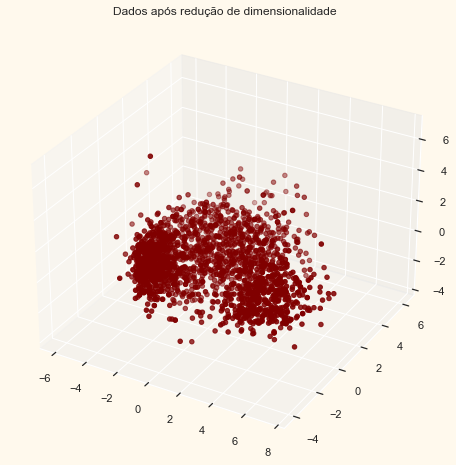

In [14]:
# Projeção 3D dos dados após a redução de dimensionalidade

x = ds_pca["col1"]
y = ds_pca["col2"]
z = ds_pca["col3"]

fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(x,y,z, c="maroon", marker="o")
ax.set_title("Dados após redução de dimensionalidade")
plt.show()

Determinando a quantidade adequada de grupos


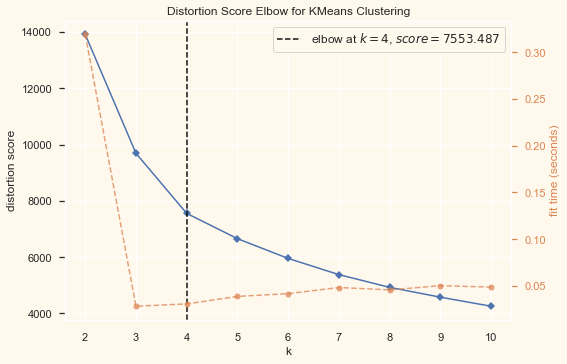

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [15]:
# CLUSTERIZAÇÃO
# Depois de reduzir a dimensionalidade dos dados para 3 dimensões será feita a clusterização a partir do método 
# hierárquico de clusterização aglomerativa.
# Os grupos serão mesclados até que seja atingida a quantidade desejada de grupos. Essa quantidade ideal pode ser
# definida através de métodos como o Elbow Method

print("Determinando a quantidade adequada de grupos")
elbow_m = KElbowVisualizer(KMeans(), k=10)
elbow_m.fit(ds_pca)
elbow_m.show()

In [17]:
# Pelo Elbow method foi indicado que o número ótimo de clusters é 4

# Modelos de Clusterização Aglomerativa

# iniciando modelo
ac = AgglomerativeClustering(n_clusters=4)

# fitting model and predicting clusters
pred_ac = ac.fit_predict(ds_pca)
ds_pca["Cluster"] = pred_ac

# adicionando a coluna de cluster ao dataframe original
df["Cluster"] = pred_ac


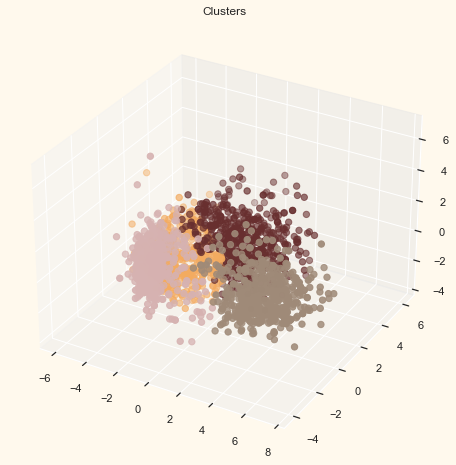

In [25]:
# Plotando os clusters

fig = plt.figure(figsize=(10,8))
ax = plt.subplot(111, projection='3d')
ax.scatter(x, y, z, s=40, c=ds_pca["Cluster"], marker='o', cmap = cmap )
ax.set_title("Clusters")
plt.show()

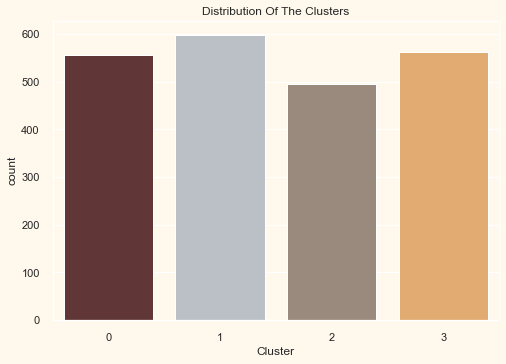

Cluster
1    598
3    563
0    556
2    495
Name: count, dtype: int64

In [30]:
# Avaliando o modelo
# Estudando os padrões dos clusters para entender melhor as características de cada um

# distribuição dos clusters

pal = ["#682F2F","#B9C0C9", "#9F8A78","#F3AB60"]
pl = sns.countplot(x=df["Cluster"], palette= pal)
pl.set_title("Distribution Of The Clusters")
plt.show()

df.value_counts("Cluster")
# Clusters aparentemente bem distribuídos

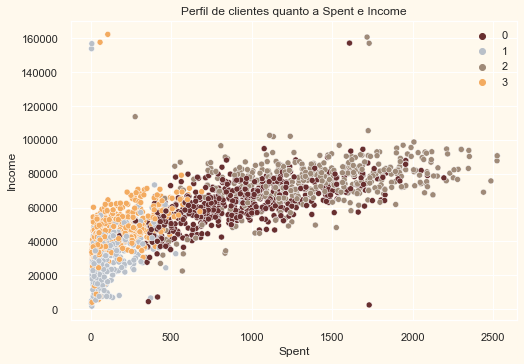

In [35]:
# analisando o valor gasto em compras nos últimos dois anos e a renda anual

pl = sns.scatterplot(data = df, x = df['Spent'], y= df['Income'], hue = df['Cluster'], palette=pal)
pl.set_title("Perfil de clientes quanto a Spent e Income")
plt.legend()
plt.show()

# 0: gasto médio/alto e médio income
# 1: gasto baixo e baixo income
# 2: gasto alto e alto/médio income
# 3: gasto baixo e baixo/médio income


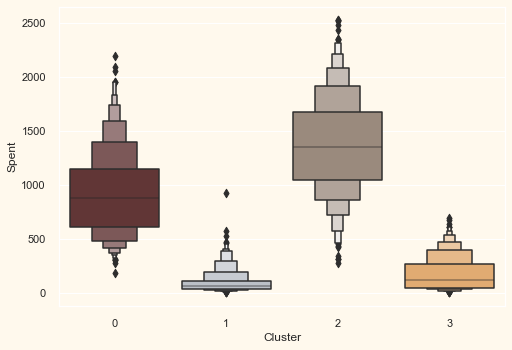

In [40]:
plt.figure()
#pl = sns.swarmplot(x = df['Cluster'], y=df['Spent'],  color= "#CBEDDD", alpha=0.5 )
pl = sns.boxenplot(x = df['Cluster'], y=df['Spent'], palette=pal)
plt.show()

# Cluster 2 tem a menor quantidade de clientes e maior valor em gastos
# Cluster 1 tem a menor quantidade de clientes e o menor valor em gastos, similar ao grupo 3

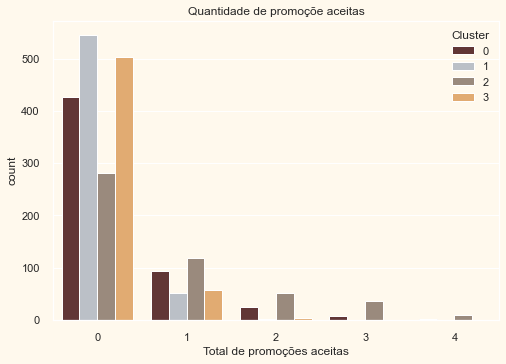

In [42]:
# Explorando as campanhas

# criando feature para pegar a soma das promoções/campanhas aceitas pelo cliente
df['TotalPromos'] = df['AcceptedCmp1'] + df['AcceptedCmp2'] + df['AcceptedCmp3'] + df['AcceptedCmp4'] + df['AcceptedCmp5']

# plotando o total de campanhas aceitas por clusters
plt.figure()
pl = sns.countplot(x = df['TotalPromos'], hue=df['Cluster'], palette=pal)
pl.set_title("Quantidade de promoçõe aceitas")
pl.set_xlabel("Total de promoções aceitas")
plt.show()

# O grupo 2 se mostrou mais susceptível às promoções, sendo o único com registros de aceitação de 4 campanhas
# Ainda assim, os dados mostram que algo deve ser feito em relação às camapnhas, devido a baixa aceitação geral

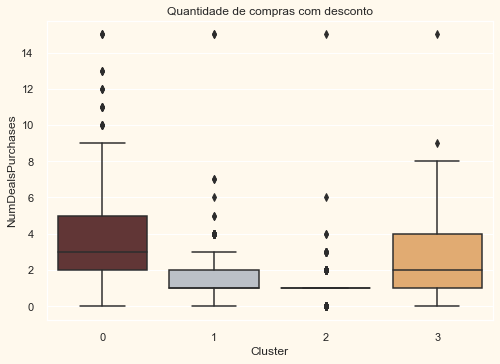

In [44]:
# plotando a quantidade de compras feitas com desconto

plt.figure()
pl = sns.boxplot(x = df['Cluster'], y= df['NumDealsPurchases'], palette=pal)
pl.set_title("Quantidade de compras com desconto")
plt.show()

# os descontos parecem atrair mais os clientes do cluster 0 e tem um efeito menor nos clientes do cluster 1
# e menor ainda nos clientes do cluster 2

<Figure size 576x396 with 0 Axes>

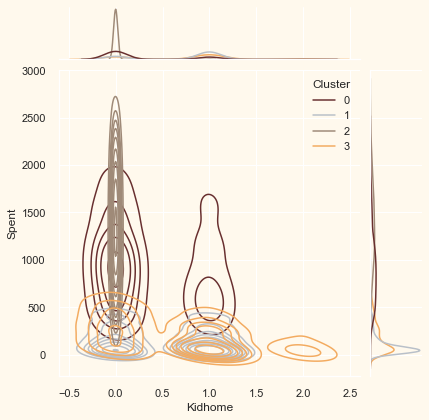

<Figure size 576x396 with 0 Axes>

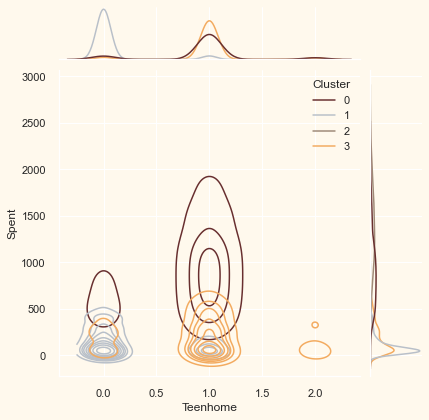

<Figure size 576x396 with 0 Axes>

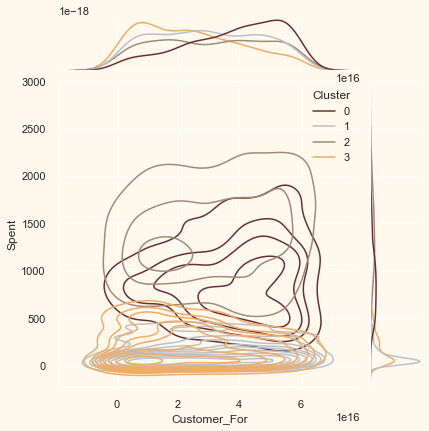

<Figure size 576x396 with 0 Axes>

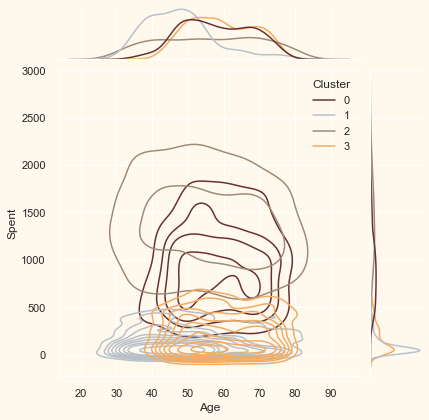

<Figure size 576x396 with 0 Axes>

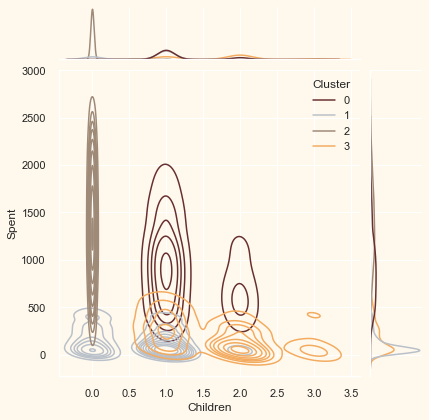

<Figure size 576x396 with 0 Axes>

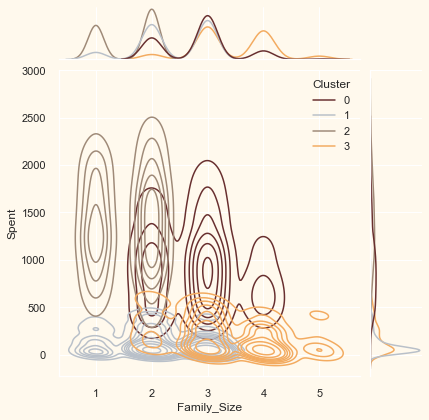

<Figure size 576x396 with 0 Axes>

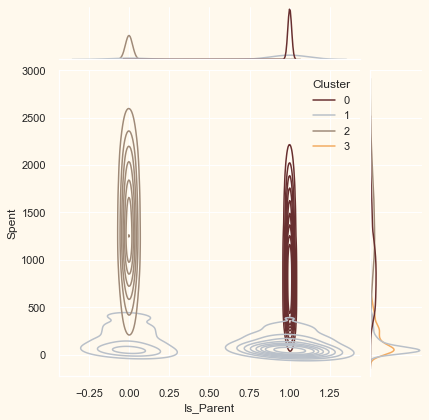

<Figure size 576x396 with 0 Axes>

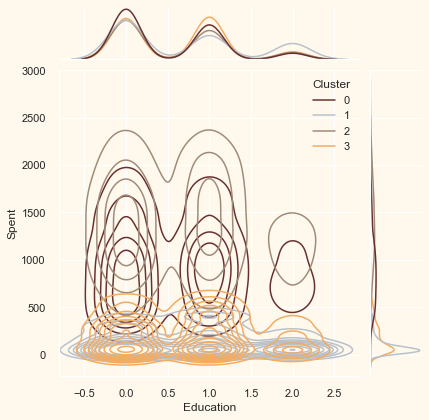

<Figure size 576x396 with 0 Axes>

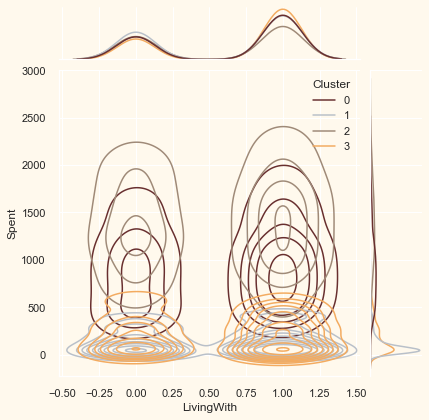

In [60]:
# Perfil - estudando os perfis dos clientes de cadas cluster

# separando as features que definem o perfil dos clientes
# queremos ver o quanto as features se relacionam com o total gasto

personal = ["Kidhome","Teenhome","Customer_For", "Age", "Children", "Family_Size", "Is_Parent", "Education","LivingWith"]

for i in personal:
    plt.figure()
    sns.jointplot(x = df[i], y=df['Spent'], hue=df['Cluster'], kind='kde', palette=pal)
    plt.show()

Kidhome: Cluster 3 tende a ter mais crianças. E cluster 2 não tem crianças em casa, ainda sim, tem maior gasto.
Teenhome: Cluster 1 majoritariamente não tem adolescentes em casa, enquanto o cluster 3 tem pelo menos 1 adolescente.
Age: Clientes do cluster 1 são mais jovens e clientes mais velhos pertencem ao cluster 2.
Children: Clientes do cluster 3 são pais e a confirmação de que clientes do cluster 2 não tem crianças/adolescentes em casa.
Family size: clientes do cluster 3 tem familias maiores e clientes do cluster 1, famílias menores.